In [3]:
import pandas as pd
import numpy as np
import datetime
import cvxpy as cp
import networkx as nx
import math
import matplotlib.pyplot as plt

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M:%S')

season = pd.read_csv("fixtures-results.csv", 
                       parse_dates={'datetime': ['Date', 'Time']}, 
                       date_parser=dateparse)


/Users/maloferriol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [18]:
season = season.where(season['Status'] != 'P').dropna(subset=["ID"]) # drop fixtures that were canceled

In [19]:
season = season.drop(columns=['ID','Status', 'H HT Score', 'A HT Score', 'Attendance'])

In [41]:
fixtures = season[season["datetime"] < datetime.datetime(2020,3,2)].drop(columns=['datetime'])
#fixtures = fixtures.drop(columns=['datetime'])
fixtures.describe().loc[['count']]


,H Score,A Score
count,270.0,270.0


In [42]:
fixtures.head()

,Home Team,H Score,A Score,Away Team
0,Monaco,0.0,3.0,Lyon
1,Angers,3.0,1.0,Bordeaux
2,Brest,1.0,1.0,Toulouse
3,Dijon,1.0,2.0,Saint Étienne
4,Marseille,0.0,2.0,Reims


In [45]:
teams = fixtures["Home Team"].unique()

# Directed Graph

In [169]:
fixtures.head()

,Home Team,H Score,A Score,Away Team,home_win,away_win,draw
0,Monaco,0.0,3.0,Lyon,0,1,0
1,Angers,3.0,1.0,Bordeaux,1,0,0
2,Brest,1.0,1.0,Toulouse,0,0,1
3,Dijon,1.0,2.0,Saint Étienne,0,1,0
4,Marseille,0.0,2.0,Reims,0,1,0


In [216]:
def graph_construction_for_home(row):
    source = row[0]
    target = row[3]
    lose = int(row[1]<row[2])
    draw = int(row[1]==row[2])
    game = 1
    concede = row[2] 
    score = row[1]
    
    return source, target, lose, game, concede, score, draw

In [217]:
def graph_construction_for_away(row):
    source = row[3]
    target = row[0]
    lose = int(row[2]<row[1])
    draw = int(row[1]==row[2])
    game = 1
    concede = row[1]
    score = row[2]

    return source, target, lose, game, concede, score, draw

In [253]:
def apply_weight(row):
    # w = (l/g)+ (d/2) + c/(c+s)
    w = row[3]/row[4] + row[0]/2
    
    if ((row[5]+row[6])!=0):
        w += row[5]/(row[5]+row[6])
    
    return w

In [254]:
del edge1, edge2

edge1 = fixtures 
edge2 = fixtures

edge1[["source", "target", "lose", "game", "concede", "score", "draw"]] = fixtures.apply(lambda x: graph_construction_for_home(x), axis=1,result_type='expand')
edge1 = edge1.drop(columns=['Home Team','H Score','A Score','Away Team','home_win','away_win'])

fixtures = fixtures.drop(columns=["source", "target", "lose", "game", "concede", "score"])

edge2[["source", "target", "lose", "game", "concede", "score", "draw"]] = fixtures.apply(lambda x: graph_construction_for_away(x), axis=1,result_type='expand')
edge2 = edge2.drop(columns=['Home Team','H Score','A Score','Away Team','home_win','away_win'])


In [255]:
df_graph = edge1.append(edge2, ignore_index=True)
graph = df_graph

In [256]:
graph["weight"] = graph.apply(lambda x: apply_weight(x), axis=1, result_type='expand')
print ( list( graph.columns ) )

['draw', 'source', 'target', 'lose', 'game', 'concede', 'score', 'weight']


In [261]:
result_dict = graph.set_index(["source","target"]).to_dict('split')
print( len(result_dict['index']) )

540


In [262]:
graph[["lose", "game", "concede", "score", "draw", "weight"]] = df_graph.groupby(['source', 'target'])[["lose", "game", "concede", "score", "draw", "weight"]].transform('sum')
graph = graph.drop_duplicates(subset=['source', 'target'])

In [263]:
records = list(graph.drop(columns=["lose", "game", "concede", "score", "draw"]).to_records(index=False))
print( len(records) )

380


### Create directed graph 

In [264]:
D=nx.DiGraph()
D.add_weighted_edges_from(records)

print("MDG.edges", len(list(D.edges())) )

MDG.edges 380


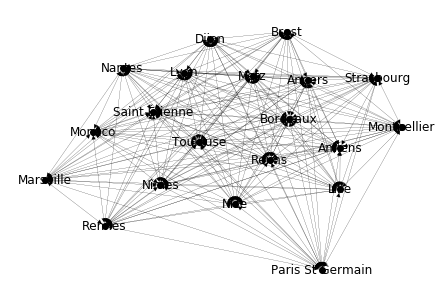

In [265]:
options = {
    'node_color': 'black',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
    'with_labels':True
}
nx.draw(D, **options)
plt.show()

### Eagenvector centrality

In [266]:
eigenvector_centrality_numpy = nx.eigenvector_centrality_numpy(D, weight='weight')

eigenvector_centrality_df = pd.DataFrame(eigenvector_centrality_numpy.items(), columns=['Team', 'centrality_score'])
sc = eigenvector_centrality_df['centrality_score']
sc_mi = sc.min()
eigenvector_centrality_df['centrality_score'] = (sc-sc_mi)/(sc.max()-sc_mi)

eigenvector_centrality_df.sort_values(by=['centrality_score'], ascending =False).reset_index(drop=True)


,Team,centrality_score
0,Paris St Germain,1.000000
1,Marseille,0.645712
2,Lille,0.574768
3,Rennes,0.553084
4,Reims,0.533565
5,Monaco,0.510526
6,Nantes,0.448489
7,Bordeaux,0.442433
8,Nice,0.439980
9,Lyon,0.425571


In [294]:
text = eigenvector_centrality_df \
    .sort_values(by=['centrality_score'], ascending =False)\
    .reset_index(drop=True)\
    .to_latex(
                index=False,
                column_format="l | r ",
                float_format="%.4f",
                #caption="{} with {} on {}".format("eigenvector", "distributed", "weight"),
                label="{} with {} on {}".format("eigenvector", "distributed", "weight")
            ) \
            .replace("half_size","half size") \
            .replace("full_size","full size") \
            .replace("_fll"," full size ") \
            .replace("_hlf"," half size ") \
            .replace("midrule","hline") \
            .replace("\n\\toprule","") \
            .replace("\\\\\n\\bottomrule","") \
            .replace("\\begin{table}","\\begin{table}[H]")

print(text)

\begin{table}[h]
\centering
\label{eigenvector with distributed on weight}
\begin{tabular}{l | r }
             Team &  centrality\_score \\
\hline
 Paris St Germain &            1.0000 \\
        Marseille &            0.6457 \\
            Lille &            0.5748 \\
           Rennes &            0.5531 \\
            Reims &            0.5336 \\
           Monaco &            0.5105 \\
           Nantes &            0.4485 \\
         Bordeaux &            0.4424 \\
             Nice &            0.4400 \\
             Lyon &            0.4256 \\
      Montpellier &            0.4187 \\
       Strasbourg &            0.3726 \\
             Metz &            0.3630 \\
            Brest &            0.3549 \\
           Angers &            0.3505 \\
            Dijon &            0.3253 \\
    Saint Étienne &            0.2768 \\
           Amiens &            0.2682 \\
            Nîmes &            0.2662 \\
         Toulouse &            0.0000 
\end{tabular}
\end{table}



In [267]:
pagerank_numpy = nx.pagerank_numpy(D, alpha=0.9, weight='weight')

pagerank_numpy_df = pd.DataFrame(pagerank_numpy.items(), columns=['Team', 'centrality_score'])
sc = pagerank_numpy_df['centrality_score']
sc_mi = sc.min()
pagerank_numpy_df['centrality_score'] = (sc-sc_mi)/(sc.max()-sc_mi)

pagerank_numpy_df.sort_values(by=['centrality_score'], ascending =False).reset_index(drop=True)

,Team,centrality_score
0,Paris St Germain,1.000000
1,Reims,0.735727
2,Rennes,0.642361
3,Marseille,0.612757
4,Monaco,0.612216
5,Lille,0.562170
6,Nantes,0.517442
7,Dijon,0.490644
8,Bordeaux,0.471432
9,Nice,0.470239


In [295]:
text = pagerank_numpy_df.sort_values(by=['centrality_score'], ascending =False)\
.reset_index(drop=True)\
.to_latex(
                index=False,
                column_format="l | r ",
                float_format="%.4f",
                #caption="{} with {} on {}".format("eigenvector", "distributed", "weight"),
                label="{} with {} on {}".format("eigenvector", "distributed", "weight")
            ) \
            .replace("half_size","half size") \
            .replace("full_size","full size") \
            .replace("_fll"," full size ") \
            .replace("_hlf"," half size ") \
            .replace("midrule","hline") \
            .replace("\n\\toprule","") \
            .replace("\\\\\n\\bottomrule","") \
            .replace("\\begin{table}","\\begin{table}[H]")

print(text)

\begin{table}[H]
\centering
\label{eigenvector with distributed on weight}
\begin{tabular}{l | r }
             Team &  centrality\_score \\
\hline
 Paris St Germain &            1.0000 \\
            Reims &            0.7357 \\
           Rennes &            0.6424 \\
        Marseille &            0.6128 \\
           Monaco &            0.6122 \\
            Lille &            0.5622 \\
           Nantes &            0.5174 \\
            Dijon &            0.4906 \\
         Bordeaux &            0.4714 \\
             Nice &            0.4702 \\
      Montpellier &            0.4094 \\
             Lyon &            0.4093 \\
           Amiens &            0.3944 \\
             Metz &            0.3810 \\
            Brest &            0.3683 \\
       Strasbourg &            0.3650 \\
           Angers &            0.3261 \\
            Nîmes &            0.2981 \\
    Saint Étienne &            0.2724 \\
         Toulouse &            0.0000 
\end{tabular}
\end{table}



## Multi Directed Graph

In [268]:
MDG=nx.MultiDiGraph()

edge_list = []
for i in range(len(result_dict['index'])):
    source = result_dict['index'][i][0]
    target = result_dict['index'][i][1]
    d = {
        'draw': result_dict['data'][i][0],
        'lose':result_dict['data'][i][1],
        'game':result_dict['data'][i][2],
        'concede':result_dict['data'][i][3],
        'score':result_dict['data'][i][4],
        'weight':result_dict['data'][i][5]
    }
    
    edge_list.append( (source,target,d) )

MDG.add_edges_from(edge_list)
print("MDG.edges", len(list(MDG.edges())) )

MDG.edges 540


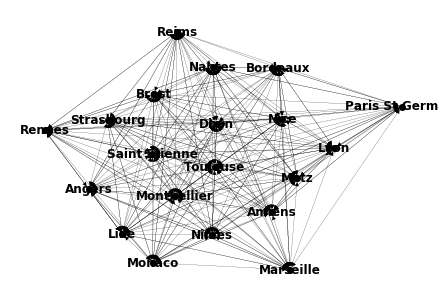

<Figure size 504x1008 with 0 Axes>

In [269]:
options = {
    'node_color': 'black',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
    'with_labels':True, 
    'font_weight':'bold'
}
nx.draw(MDG, **options)
plt.figure(figsize=(7,14))
plt.show()

In [271]:
c = nx.pagerank_numpy(MDG, alpha=0.9, weight='concede')
d = nx.pagerank_numpy(MDG, alpha=0.9, weight='draw')
l = nx.pagerank_numpy(MDG, alpha=0.9, weight='lose')
s = nx.pagerank_numpy(MDG, alpha=0.9, weight='score')

total = {}
for team in teams:
    t = (c.get(team) / (c.get(team)+ s.get(team)) ) + (d.get(team)/2) + l.get(team) 
    total[team] = t
    
total_df = pd.DataFrame(total.items(), columns=['Team', 'centrality_score'])
sc = total_df['centrality_score']
sc_mi = sc.min()
total_df['centrality_score'] = (sc-sc_mi)/(sc.max()-sc_mi)

total_df.sort_values(by=['centrality_score'], ascending =False).reset_index(drop=True)

,Team,centrality_score
0,Paris St Germain,1.000000
1,Marseille,0.648107
2,Lyon,0.622900
3,Reims,0.612664
4,Monaco,0.579434
5,Rennes,0.575864
6,Bordeaux,0.571759
7,Montpellier,0.541136
8,Lille,0.536252
9,Nice,0.482390


In [296]:
text = total_df.sort_values(by=['centrality_score'], ascending =False)\
.reset_index(drop=True)\
.to_latex(
                index=False,
                column_format="l | r ",
                float_format="%.4f",
                #caption="{} with {} on {}".format("eigenvector", "distributed", "weight"),
                label="{} with {} on {}".format("eigenvector", "distributed", "weight")
            ) \
            .replace("half_size","half size") \
            .replace("full_size","full size") \
            .replace("_fll"," full size ") \
            .replace("_hlf"," half size ") \
            .replace("midrule","hline") \
            .replace("\n\\toprule","") \
            .replace("\\\\\n\\bottomrule","") \
            .replace("\\begin{table}","\\begin{table}[H]")

print(text)

\begin{table}[H]
\centering
\label{eigenvector with distributed on weight}
\begin{tabular}{l | r }
             Team &  centrality\_score \\
\hline
 Paris St Germain &            1.0000 \\
        Marseille &            0.6481 \\
             Lyon &            0.6229 \\
            Reims &            0.6127 \\
           Monaco &            0.5794 \\
           Rennes &            0.5759 \\
         Bordeaux &            0.5718 \\
      Montpellier &            0.5411 \\
            Lille &            0.5363 \\
             Nice &            0.4824 \\
           Nantes &            0.4513 \\
            Dijon &            0.4331 \\
           Amiens &            0.3971 \\
       Strasbourg &            0.3860 \\
           Angers &            0.3572 \\
            Brest &            0.3437 \\
            Nîmes &            0.3216 \\
             Metz &            0.2769 \\
    Saint Étienne &            0.1729 \\
         Toulouse &            0.0000 
\end{tabular}
\end{table}



In [272]:
c = nx.eigenvector_centrality_numpy(MDG, weight='concede')
d = nx.eigenvector_centrality_numpy(MDG, weight='draw')
l = nx.eigenvector_centrality_numpy(MDG, weight='lose')
s = nx.eigenvector_centrality_numpy(MDG, weight='score')

total_ec = {}
for team in teams:
    t = (c.get(team) / (c.get(team)+ s.get(team)) ) + (d.get(team)/2) + l.get(team) 
    total_ec[team] = t

total_ec_df = pd.DataFrame(total_ec.items(), columns=['Team', 'centrality_score'])
sc = total_ec_df['centrality_score']
sc_mi = sc.min()
total_ec_df['centrality_score'] = (sc-sc_mi)/(sc.max()-sc_mi)

total_ec_df.sort_values(by=['centrality_score'], ascending =False).reset_index(drop=True)

,Team,centrality_score
0,Paris St Germain,1.000000
1,Marseille,0.714563
2,Reims,0.641040
3,Lyon,0.606510
4,Rennes,0.602952
5,Lille,0.560882
6,Bordeaux,0.558347
7,Monaco,0.534113
8,Montpellier,0.532794
9,Nice,0.471693


In [297]:
text = total_ec_df.sort_values(by=['centrality_score'], ascending =False)\
.reset_index(drop=True)\
.to_latex(
                index=False,
                column_format="l | r ",
                float_format="%.4f",
                #caption="{} with {} on {}".format("eigenvector", "distributed", "weight"),
                label="{} with {} on {}".format("eigenvector", "distributed", "weight")
            ) \
            .replace("half_size","half size") \
            .replace("full_size","full size") \
            .replace("_fll"," full size ") \
            .replace("_hlf"," half size ") \
            .replace("midrule","hline") \
            .replace("\n\\toprule","") \
            .replace("\\\\\n\\bottomrule","") \
            .replace("\\begin{table}","\\begin{table}[H]")

print(text)

\begin{table}[H]
\centering
\label{eigenvector with distributed on weight}
\begin{tabular}{l | r }
             Team &  centrality\_score \\
\hline
 Paris St Germain &            1.0000 \\
        Marseille &            0.7146 \\
            Reims &            0.6410 \\
             Lyon &            0.6065 \\
           Rennes &            0.6030 \\
            Lille &            0.5609 \\
         Bordeaux &            0.5583 \\
           Monaco &            0.5341 \\
      Montpellier &            0.5328 \\
             Nice &            0.4717 \\
           Nantes &            0.4437 \\
       Strasbourg &            0.4338 \\
            Dijon &            0.4030 \\
            Brest &            0.3909 \\
           Angers &            0.3703 \\
             Metz &            0.3369 \\
           Amiens &            0.3030 \\
            Nîmes &            0.2886 \\
    Saint Étienne &            0.2576 \\
         Toulouse &            0.0000 
\end{tabular}
\end{table}

